In [6]:
from keras.applications.resnet50 import ResNet50
from keras import layers
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten

num_classes = 2
pre_trained_model = ResNet50(input_shape = (224, 224, 3), include_top = False, pooling = 'avg', weights = 'imagenet')

for layer in pre_trained_model.layers: 
    layer.trainable = False
    
final_layer = pre_trained_model.layers[-1]
print('final layer output shape: ', final_layer.output_shape)
final_output = final_layer.output



final layer output shape:  (None, 2048)


In [8]:
from tensorflow.keras.optimizers import Adam
x = layers.Flatten()(final_output)

x = layers.Dense(100, activation='relu')(x)
x = layers.Dropout(0.5)(x)                  

x = layers.Dense  (num_classes, activation='softmax')(x) 

my_new_model = Model( pre_trained_model.input, x) 

my_new_model.compile(optimizer = Adam(lr=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])


my_new_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [9]:

from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import preprocess_input

image_size = 224
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)


train_generator = data_generator.flow_from_directory(
        './training',
        target_size=(image_size, image_size),
        batch_size=5,
        class_mode='categorical')

validation_generator = data_generator.flow_from_directory(
        './validation',
        target_size=(image_size, image_size),
        class_mode='categorical')

history = my_new_model.fit(
        train_generator,
        epochs = 50,
        steps_per_epoch=5,
        validation_data=validation_generator,
        validation_steps=1)

Found 62 images belonging to 2 classes.
Found 27 images belonging to 2 classes.
Epoch 1/50
5/5 [==============================] - 6s 1s/step - loss: 0.9586 - accuracy: 0.4545 - val_loss: 0.7772 - val_accuracy: 0.3704
Epoch 2/50
5/5 [==============================] - 5s 982ms/step - loss: 1.1579 - accuracy: 0.5200 - val_loss: 0.7559 - val_accuracy: 0.4815
Epoch 3/50
5/5 [==============================] - 5s 901ms/step - loss: 0.6351 - accuracy: 0.7273 - val_loss: 0.7302 - val_accuracy: 0.5185
Epoch 4/50
5/5 [==============================] - 5s 1s/step - loss: 0.6801 - accuracy: 0.6800 - val_loss: 0.7100 - val_accuracy: 0.5185
Epoch 5/50
5/5 [==============================] - 5s 1s/step - loss: 0.6877 - accuracy: 0.6400 - val_loss: 0.7009 - val_accuracy: 0.5185
Epoch 6/50
5/5 [==============================] - 5s 1s/step - loss: 0.6196 - accuracy: 0.5909 - val_loss: 0.6942 - val_accuracy: 0.5556
Epoch 7/50
5/5 [==============================] - 5s 1s/step - loss: 0.6730 - accuracy: 0.64

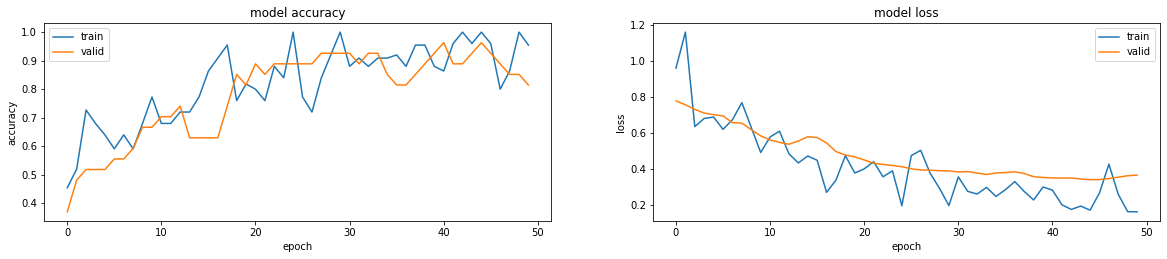

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline 

#import cv2
plt.figure(1, figsize = (20,8)) 
plt.subplot(221)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

#### Save the model

In [11]:
my_new_model.save("model.h5")

#### Test images are kept in a single subdirectory "All". They are prefixed GOOD or BAD to check the ground truth after the model evaluates the images

In [12]:
test_generator = data_generator.flow_from_directory(
    directory = './test',
    target_size = (image_size, image_size),
    batch_size = 1,
    class_mode = None,
    shuffle = False,
    seed = 101
)

Found 16 images belonging to 2 classes.


#### Load the saved model to test the unseen samples

In [13]:
from keras.models import load_model
my_loaded_model = load_model("model.h5")
my_loaded_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [14]:
import numpy as np
test_generator.reset()

pred = my_loaded_model.predict(test_generator, steps = len(test_generator), verbose = 1)

predicted_class_indices = np.argmax(pred, axis = 1)

16/16 [==============================] - 2s 137ms/step


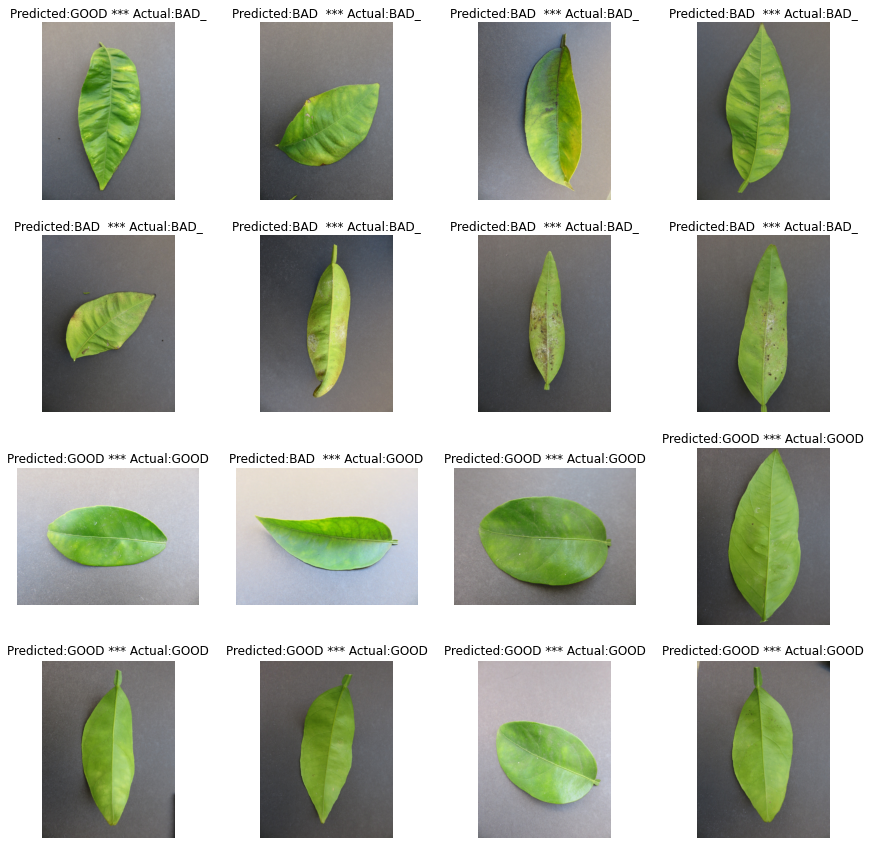

In [15]:
import cv2

TEST_DIR = './test/'
f, ax = plt.subplots(4, 4, figsize = (15, 15))

for i in range(0,16):
    imgBGR = cv2.imread(TEST_DIR + test_generator.filenames[i])
    imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
    fname = TEST_DIR + test_generator.filenames[i]
    aname = fname.split('/')[2].split('\\')[1][:4]
    
    
    # Good if condition else Bad
    predicted_class = "GOOD" if predicted_class_indices[i] else "BAD "

    ax[i//4, i%4].imshow(imgRGB)
    ax[i//4, i%4].axis('off')
    ax[i//4, i%4].set_title("Predicted:{} *** Actual:{}".format(predicted_class, aname))    

plt.show()